#  EMF RBM Omniglot

### Binarized, 200 Epochs, faster learning rate, with momentum

Look at different ways of computing the

- energy density
- free energy density
- entropy density

We can

- use the TAP S and MF Energy *U_naive   
    - which takes an equlibration step first  
    - S(mv, mh), U_naive(mv, mh)
- use a simple h = means_hiddens() step
    - S(v, h), E_MF(v, h)


In [1]:
import numpy as np
import h5py

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import linear_model, datasets, metrics, preprocessing 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

import psutil

/Users/charlesmartin14/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/charlesmartin14/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.datasets import fetch_mldata
from sklearn.utils.validation import assert_all_finite
from scipy.sparse import csc_matrix, csr_matrix, lil_matrix
from sklearn.preprocessing import Binarizer
np.seterr(all='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib as mpl

def show_image(image): 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.show()

In [4]:
import rbm_datasets

In [5]:
train_x, train_y, train_char, test_x, test_y, test_char = rbm_datasets.load_omniglot_iwae()

In [6]:
from sklearn.preprocessing import binarize
X_train = binarize(train_x, threshold=0.5, copy=True)

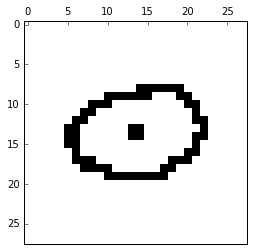

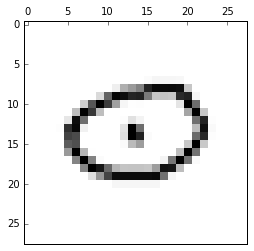

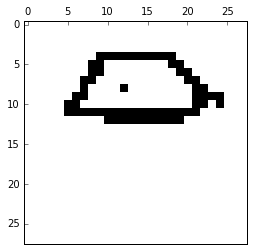

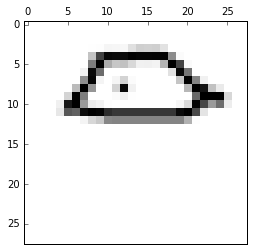

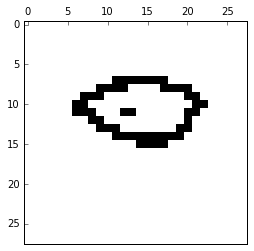

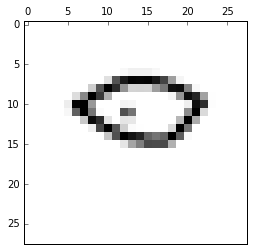

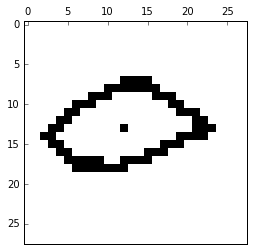

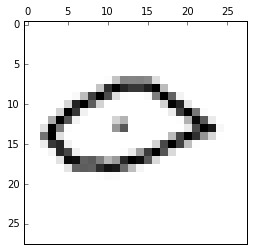

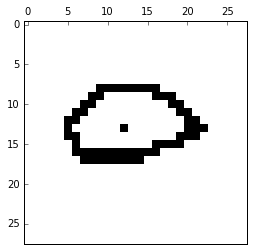

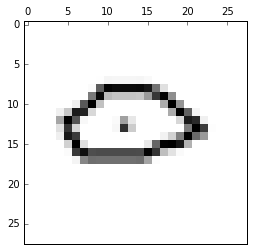

In [7]:
for i in range(5):
    show_image(X_train[i+100].reshape(28,28))
    show_image(train_x[i+100].reshape(28,28))

In [8]:
X_train.shape

(24345, 784)

### EMF RBM

In [9]:
psutil.swap_memory()

sswap(total=9663676416L, used=7910719488L, free=1752956928L, percent=81.9, sin=64430620672L, sout=624091136L)

### mean Entropy, Energy, and Free Energy

need to grid search these parameters and plot

In [12]:
import emf_rbm
rbm = emf_rbm.EMF_RBM(verbose=True, monitor=True, learning_rate=0.1, n_iter=20,momentum=0.25, sigma=0.01, decay=0.1)
print rbm
rbm= rbm.fit(X_train)

EMF_RBM(batch_size=100, decay=0.1, learning_rate=0.1, momentum=0.25,
    monitor=True, n_components=256, n_iter=20, neq_steps=3,
    random_state=<mtrand.RandomState object at 0x106e7a3c0>, sigma=0.01,
    thresh=1e-08, verbose=True, weight_decay='L1')
[EMF_RBM] Iteration 1, pseudo-likelihood = -148.13, time = 6.34s
computing TAP Free Energies
monitor:  -181.827475361 286.062118642 106.880495497
[EMF_RBM] Iteration 2, pseudo-likelihood = -129.24, time = 15.35s
computing TAP Free Energies
monitor:  -177.063406042 257.423971435 86.6211306868
[EMF_RBM] Iteration 3, pseudo-likelihood = -115.13, time = 15.73s
computing TAP Free Energies
monitor:  -185.663694989 244.436920555 68.3220989913
[EMF_RBM] Iteration 4, pseudo-likelihood = -104.67, time = 18.72s
computing TAP Free Energies
monitor:  -197.70002331 235.179934571 49.6281101364
[EMF_RBM] Iteration 5, pseudo-likelihood = -100.64, time = 16.70s
computing TAP Free Energies
monitor:  -211.173697537 228.738151639 31.7645808548
[EMF_RBM] Iter

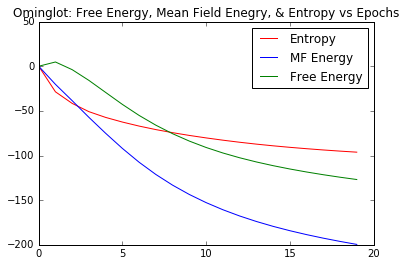

In [13]:
plt.plot(rbm.entropies-rbm.entropies[0], color='red', label='Entropy')
plt.plot(rbm.mean_field_energies-rbm.mean_field_energies[0], color='blue', label='MF Energy')
plt.plot(rbm.free_energies-rbm.free_energies[0], color='green', label='Free Energy')
plt.legend(loc='upper right')
plt.title("Ominglot: Free Energy, Mean Field Enegry, & Entropy vs Epochs")


### Entropy does not flatline so fast

In [14]:
from sklearn.preprocessing import binarize
X_test = binarize(test_x, threshold=0.5, copy=True)

In [15]:
np.unique(train_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [18]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

F_train = rbm.transform(X_train)
F_test = rbm.transform(X_test)

for c in [0.01, 0.1, 1, 10, 100]:
    classifier = LinearSVC(C=c)
    classifier.fit(F_train, train_y)
    test_emf_rbm_pred_y = classifier.predict(F_test)
    emf_accuracy = accuracy_score(y_pred=test_emf_rbm_pred_y, y_true=test_y)
    print classifier, emf_accuracy

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 0.256133828996
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 0.260346964064
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 0.26009913259
LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 0.212639405204
LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_s